# Flux pumping
Gengyan Zhang, September 7 2016

When the qubit frequency $\omega_q$ and cavity frequency $\omega_r$ are detuned from each other, an effective resonant interaction can be generated by modulating the qubit frequency at $\omega_r-\omega_q$.
## Reference
[Strand JD, Ware M, Beaudoin F, Ohki TA, Johnson BR, Blais A, et al. First-order sideband transitions with flux-driven asymmetric transmon qubits. Physical Review B  **87**, 220505 (2013).](http://link.aps.org/doi/10.1103/PhysRevB.87.220505)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from IPython.display import display, Markdown
plt.rc('font', size=16)

## Parameters

In [2]:
# Parameters
Nmax = 10
delta = 400e6*2*np.pi
g = 129e6*2*np.pi
kappa = 0.37e6
gamma = 1/10e-6
# Operators
a = qt.tensor(qt.destroy(Nmax), qt.qeye(2))
adag = a.dag()
sx = qt.tensor(qt.qeye(Nmax), qt.sigmax())
sy = qt.tensor(qt.qeye(Nmax), qt.sigmay())
sz = qt.tensor(qt.qeye(Nmax), qt.sigmaz())
sp = qt.tensor(qt.qeye(Nmax), qt.sigmap())
sm = qt.tensor(qt.qeye(Nmax), qt.sigmam())
# Hamiltonian (in rotating frame of bare qubit frequency)
H0 = delta*adag*a + g*(adag*sm + a*sp)

## Dressed states, frequencies and operators
The dressed states and their frequencies can be calculated by diagonalizing the Hamiltonian:

In [3]:
eigvals, eigvecs = H0.eigenstates()
print('Eigen eneriges (in MHz) of dressed states:')
for ii in range(0, 6):
    print(eigvals[ii]/(2*np.pi)/1e6)

Eigen eneriges (in MHz) of dressed states:
-37.9936973955
0.0
329.293516886
437.993697396
700.128360794
870.706483114


So the dressed frequencies are $E_{|e0\rangle}$ = -37.99 MHz, $E_{|g0\rangle}$ = 0, $E_{|e1\rangle}$ = 329.29 MHz, $E_{|g1\rangle}$ = 437.99 MHz, ...  
We can construct the dressed Pauli and ladder operators from the eigenstates:

In [4]:
szD = 0*qt.tensor(qt.qeye(Nmax), qt.qeye(2))
nD = 0*qt.tensor(qt.qeye(Nmax), qt.qeye(2))
for ii in np.arange(0, len(eigvecs), 2):
    # Dressed |e, n=ii/2> state
    psiE = eigvecs[ii].unit()
    # Dressed |g, n=ii/2> state
    psiG = eigvecs[ii+1].unit()
    # Dressed sigmaz operator
    szD = szD + psiE*psiE.dag() - psiG*psiG.dag()
    # Dressed photon number operator
    nD = nD + ii/2*(psiE*psiE.dag() + psiG*psiG.dag())

## Apply modulation to qubit frequency

In [5]:
def fluxPump(freq, amp, psi0, tlist):
    # freq: modulation frequency
    # amp: modulation amplitude
    # psi0: initial state
    # tlist: time axis
    # Returns: the expectation value of dressed sigmaz and adag*a for each time step
    args = {'freq': freq}
    H = [H0, [amp*sz, lambda t, args:np.sin(2*np.pi*args['freq']*t)]]
    result = qt.mesolve(H, psi0, tlist,
                        c_ops=[np.sqrt(kappa)*a, np.sqrt(gamma)*sm],
                        e_ops=[szD, nD], args=args)
    return np.real(result.expect[0]), np.real(result.expect[1])

# Initial state
psi0 = eigvecs[0]
# Time axis
tlist = np.linspace(0, 200e-9, 1001)
# Sweep modulation frequency
freqlist = np.linspace(435e6, 515e6, 21)
# Modulation amplitude
amp = 50e6*2*np.pi

print('Solving master equation ...')
result = qt.parallel_map(fluxPump, freqlist, task_args=(amp, psi0, tlist),
                         progress_bar=True)
szarray = np.array([r[0] for r in result]).T
narray = np.array([r[1] for r in result]).T

# Pick the modulation frequency as the difference between (dressed) cavity and qubit
freq = (eigvals[3]-eigvals[0])/(2*np.pi)
szlist, nlist = fluxPump(freq, amp, psi0, tlist)

Solving master equation ...
14.3%. Run time:  11.25s. Est. time left: 00:00:01:07
23.8%. Run time:  21.87s. Est. time left: 00:00:01:09
33.3%. Run time:  22.13s. Est. time left: 00:00:00:44
42.9%. Run time:  33.22s. Est. time left: 00:00:00:44
52.4%. Run time:  33.61s. Est. time left: 00:00:00:30
61.9%. Run time:  44.11s. Est. time left: 00:00:00:27
71.4%. Run time:  45.24s. Est. time left: 00:00:00:18
81.0%. Run time:  55.32s. Est. time left: 00:00:00:13
90.5%. Run time:  57.23s. Est. time left: 00:00:00:06
100.0%. Run time:  62.46s. Est. time left: 00:00:00:00
Total run time:  62.48s


## Results

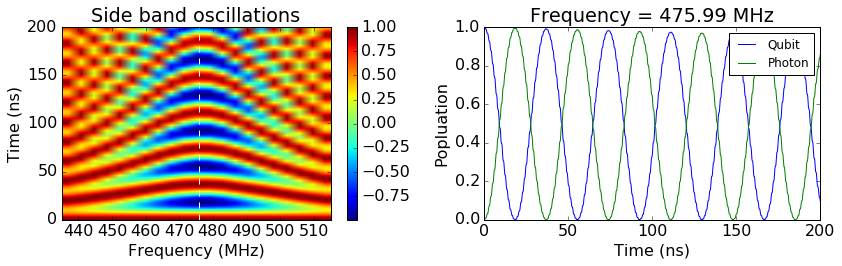

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(szarray, extent=[freqlist[0]/1e6, freqlist[-1]/1e6,
                            tlist[0]/1e-9, tlist[-1]/1e-9],
           origin='lower', aspect=0.5)
plt.colorbar()
plt.plot([freq/1e6, freq/1e6], [tlist[0]/1e-9, tlist[-1]/1e-9], 'w--')
plt.axis('tight')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time (ns)')
plt.title('Side band oscillations')

plt.subplot(122)
plt.plot(tlist/1e-9, (szlist+1)/2, tlist/1e-9, nlist)
plt.xlabel('Time (ns)')
plt.ylabel('Popluation')
plt.legend(['Qubit', 'Photon'], fontsize=12)
plt.title('Frequency = %.2f MHz' % (freq/1e6))

plt.tight_layout()
plt.show()

We get the expected chevron pattern (see fig. 3 in ref). The coupling is maximized when the modulation frequency matches the energy difference between the (dressed) qubit and cavity, which is $E_{|g1\rangle}-E_{|e0\rangle}$ = 475.99 MHz (white dashed line in left figure).

In [7]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,3.2.0.dev-88e1862
Numpy,1.11.1
SciPy,0.18.0
matplotlib,1.5.1
Cython,0.24.1
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,5.1.0
Python,"3.5.2 |Continuum Analytics, Inc.| (default, Jul 2 2016, 17:53:06) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]
